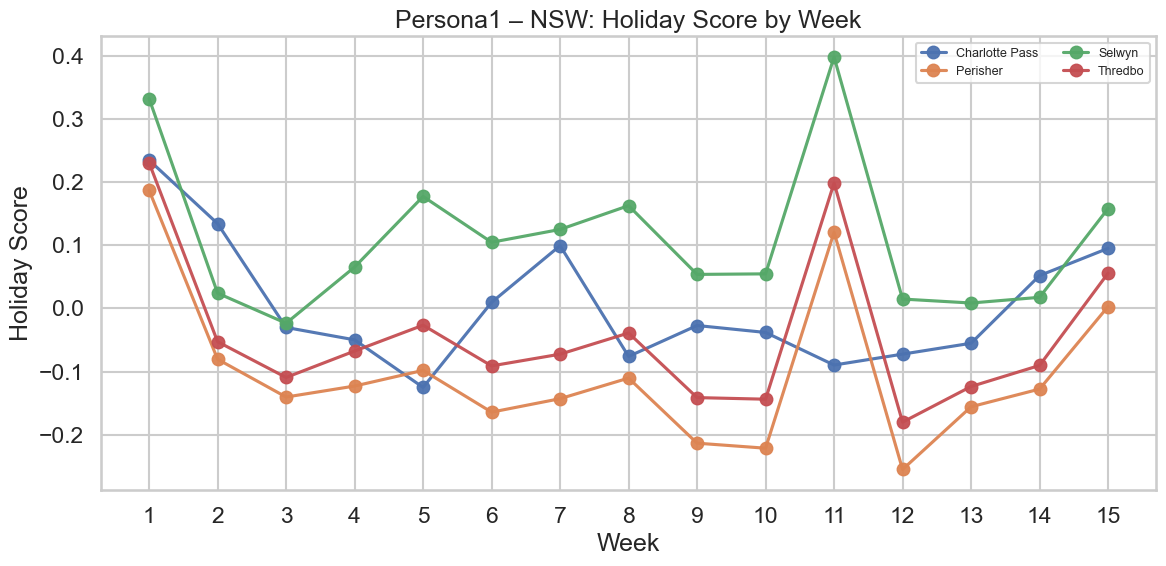

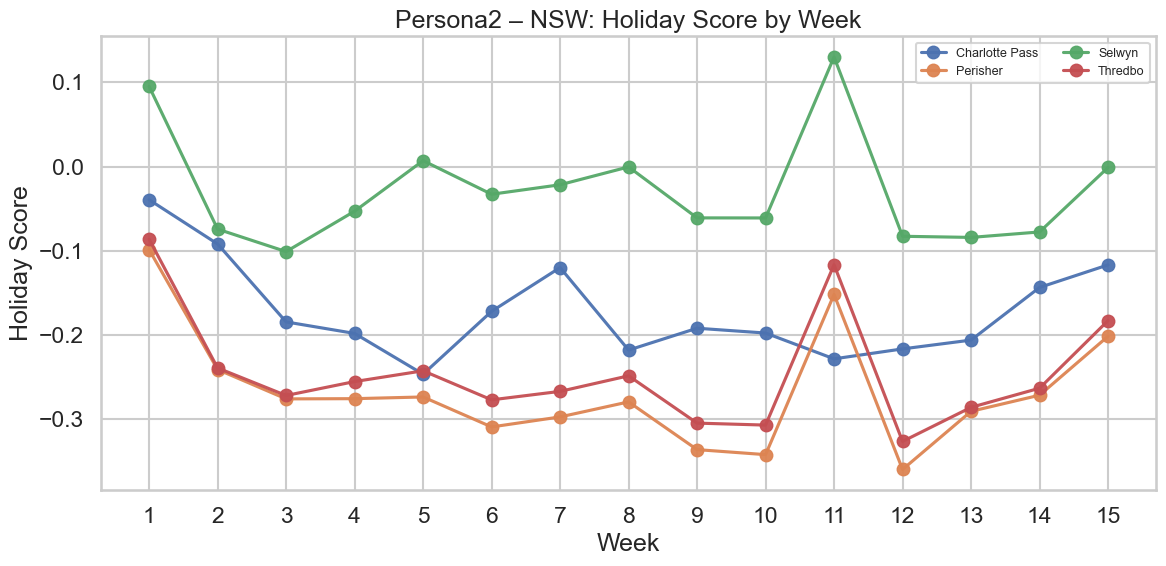

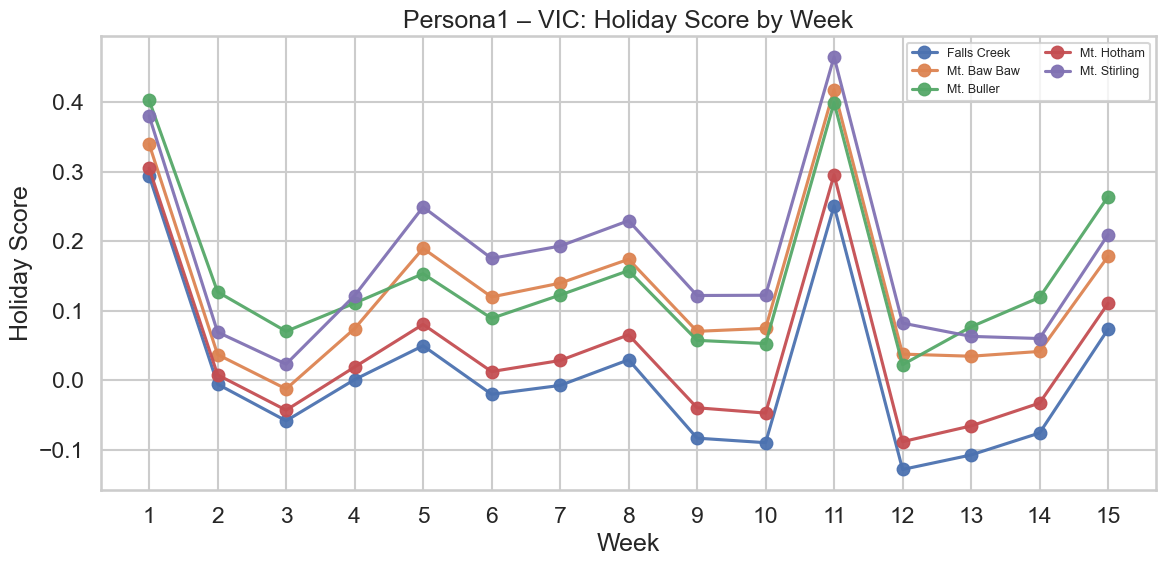

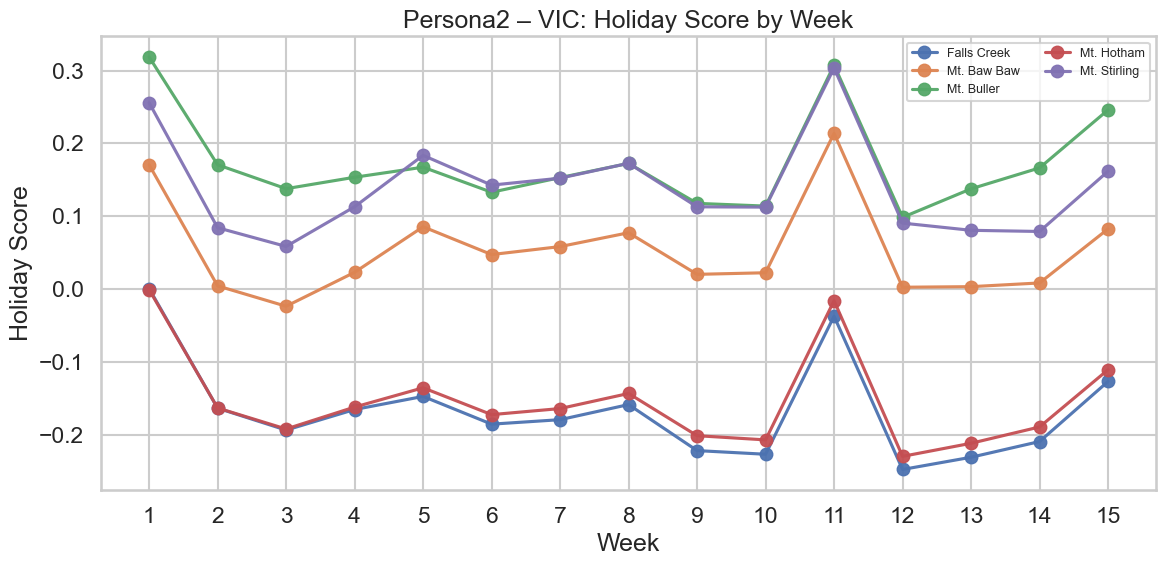

Saved plots to: C:\Users\Suman\Downloads\R2B2\src\holiday_score_plots


In [ ]:
# Plot Holiday Score by Week per State × Persona

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

CSV_PATH = r"C:\Users\Suman\Downloads\R2B2\predictive\output\2026_holiday_score_pred.csv"

sns.set_theme(style="whitegrid", context="talk")

# load and normalize names
df = pd.read_csv(CSV_PATH)
df.columns = [re.sub(r"\W+", "_", c.strip().lower()) for c in df.columns]

# pick id columns
def pick(cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

week_col   = pick(["week", "ski_week"])
state_col  = pick(["state", "resort_state", "region_state"])
resort_col = pick(["resort", "location", "resort_name", "mountain"])

# use ONLY holiday score columns (ignore snow_score)
holiday_cols = [c for c in df.columns if c.startswith("holiday_score_")]
if not holiday_cols:
    raise ValueError("No 'holiday_score_*' columns found. Check the file headers.")

id_cols = [c for c in [week_col, state_col, resort_col] if c]
tidy = df[id_cols + holiday_cols].melt(
    id_vars=id_cols, var_name="persona_raw", value_name="holiday_score"
)

# clean persona names: 'holiday_score_persona1' -> 'Persona 1'
tidy["persona"] = (
    tidy["persona_raw"]
        .str.replace(r"^holiday_score_", "", regex=True)
        .str.replace("_", " ")
        .str.title()
)

# basic typing/labels
try:
    tidy["week"] = tidy[week_col].astype(int)
except Exception:
    tidy["week"] = tidy[week_col].astype(str).str.extract(r"(\d+)").astype(int)

tidy["state"] = tidy[state_col].astype(str).str.upper()
tidy["resort"] = tidy[resort_col].astype(str)
tidy = tidy.dropna(subset=["holiday_score"])

# plotting: one figure per (state, persona)
outdir = Path("holiday_score_plots")
outdir.mkdir(parents=True, exist_ok=True)

states   = sorted(tidy["state"].unique())
personas = sorted(tidy["persona"].unique())

for st in states:
    for pe in personas:
        sub = tidy[(tidy["state"] == st) & (tidy["persona"] == pe)].copy()
        if sub.empty:
            continue
        sub = sub.sort_values(["resort", "week"])

        # sensible y-range per panel
        ymin = sub["holiday_score"].min()
        ymax = sub["holiday_score"].max()
        pad  = max(0.02, 0.05*(ymax - ymin))  # small padding
        ylo, yhi = ymin - pad, ymax + pad

        plt.figure(figsize=(12, 6))
        for resort, g in sub.groupby("resort"):
            plt.plot(g["week"], g["holiday_score"], marker="o", label=resort, alpha=0.95)
        plt.title(f"{pe} – {st}: Holiday Score by Week")
        plt.xlabel("Week"); plt.ylabel("Holiday Score")
        plt.xticks(sorted(sub["week"].unique()))
        plt.ylim(ylo, yhi)
        plt.legend(loc="best", fontsize=9, ncol=2)
        plt.tight_layout()

        fn = outdir / f"holiday_score_{st}_{pe}.png"
        plt.savefig(fn, dpi=150)
        plt.show()

print(f"Saved plots to: {outdir.resolve()}")
